# Part 7 - Plot Claims
- toc: True
- badges: true
- comments: true
- categories: [jupyter]

Plot the regular state Initial and Continued claims data alongside the Pandemic claims data

Not required

In [8]:
import os
import sys
import inspect
import datetime
import traceback
import re
import pandas as pd
import numpy as np
from plotnine import ggplot
import matplotlib.pyplot as plt

In [9]:
data_dir = "./data"
fnames = os.listdir(data_dir)
dfs = {}
for fname in fnames:
    fpath = os.path.join(data_dir, fname)
    head, tail = os.path.split(fpath)
    fbase,ext = os.path.splitext(tail)
    if os.path.isfile(fpath) and ext == ".csv":
        df = pd.read_csv(fpath)
        print("{0}  shape:{1}".format(fbase,df.shape))
        dfs[fbase] = df

google_trends  shape:(103, 21)
tidy_fred  shape:(897, 18)
umich_exp  shape:(159, 5)
us_pau_claims  shape:(58, 4)


In [20]:
fred_df = dfs["tidy_fred"]
claims_cols = [c for c in fred_df.columns if re.search("date|CCSA|ICSA", c)]
# note the use of copy here
fred_claims = fred_df[claims_cols].copy()
print(fred_claims.dtypes)
try:
  x = fred_claims["date"].apply(lambda x: pd.to_datetime(x))
  print("date shape: {0}".format(x.shape))
  fred_claims["date"] = x
  print(" done, <{0}>".format(datetime.datetime.now()))
except Exception as e:
  exc_type, exc_obj, exc_tb = sys.exc_info()
  traceback.print_tb(exc_tb)
  fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
  msg = "exc_type= {0}, exc_obg= {1}".format(exc_type, exc_obj)
  raise RuntimeError(msg)
else:
  display(fred_claims.tail(2))

date                        object
ICSA: Initial Claims       float64
CCSA: Continued Claims     float64
dtype: object
date shape: (897,)
 done, <2021-05-10 23:42:51.637183>


,date,ICSA: Initial Claims,CCSA: Continued Claims
895,2021-04-24,553000.0,3690000.0
896,2021-05-01,498000.0,NaN


In [4]:

pau_claims = dfs['us_pau_claims']
display(pau_claims.tail(2))
pau_claims["date"] = pd.to_datetime(pau_claims["date"])

display(fred_claims.tail(5))
display(pau_claims.tail(5))

claims_df = fred_claims.merge(pau_claims, how="outer", on="date")
claims_df.set_index(keys="date", inplace=True)
display(claims_df.tail(5))


,date,PUA IC,PUA CC,PEUC CC
56,2021-05-01,101214,6862705.0,4972507.0
57,2021-05-08,101214,NaN,NaN


,date,ICSA: Initial Claims,CCSA: Continued Claims
892,2021-04-03,744000.0,3731000.0
893,2021-04-10,576000.0,3674000.0
894,2021-04-17,547000.0,3660000.0
895,2021-04-24,553000.0,3690000.0
896,2021-05-01,498000.0,NaN


,date,PUA IC,PUA CC,PEUC CC
53,2021-04-10,129697,7309604.0,5605935.0
54,2021-04-17,133342,6974909.0,5194099.0
55,2021-04-24,121414,6862705.0,4972507.0
56,2021-05-01,101214,6862705.0,4972507.0
57,2021-05-08,101214,NaN,NaN


,ICSA: Initial Claims,CCSA: Continued Claims,PUA IC,PUA CC,PEUC CC
date,,,,,
2021-04-10,576000.0,3674000.0,129697.0,7309604.0,5605935.0
2021-04-17,547000.0,3660000.0,133342.0,6974909.0,5194099.0
2021-04-24,553000.0,3690000.0,121414.0,6862705.0,4972507.0
2021-05-01,498000.0,NaN,101214.0,6862705.0,4972507.0
2021-05-08,NaN,NaN,101214.0,NaN,NaN


In [5]:
claims_df.sort_index( inplace=True)
print(claims_df.columns)
display(claims_df.tail(2))
ic_df = claims_df[[claims_cols[1], 'PUA IC']].dropna(how="all")
ic_df["IC_all"] = ic_df.sum(axis=1, skipna=False)
cc_df = claims_df[[claims_cols[2], 'PUA CC', 'PEUC CC']].dropna(how="all")
cc_df["CC_all"] = cc_df.sum(axis=1, skipna=False)

ic_df.reset_index(inplace=True)
cc_df.reset_index(inplace=True)
display(cc_df.tail(4))
display(ic_df.tail(4))

Index(['ICSA: Initial Claims', 'CCSA: Continued Claims ', 'PUA IC', 'PUA CC',
       'PEUC CC'],
      dtype='object')


,ICSA: Initial Claims,CCSA: Continued Claims,PUA IC,PUA CC,PEUC CC
date,,,,,
2021-05-01,498000.0,NaN,101214.0,6862705.0,4972507.0
2021-05-08,NaN,NaN,101214.0,NaN,NaN


,date,CCSA: Continued Claims,PUA CC,PEUC CC,CC_all
744,2021-04-10,3674000.0,7309604.0,5605935.0,16589539.0
745,2021-04-17,3660000.0,6974909.0,5194099.0,15829008.0
746,2021-04-24,3690000.0,6862705.0,4972507.0,15525212.0
747,2021-05-01,NaN,6862705.0,4972507.0,NaN


,date,ICSA: Initial Claims,PUA IC,IC_all
745,2021-04-17,547000.0,133342.0,680342.0
746,2021-04-24,553000.0,121414.0,674414.0
747,2021-05-01,498000.0,101214.0,599214.0
748,2021-05-08,NaN,101214.0,NaN


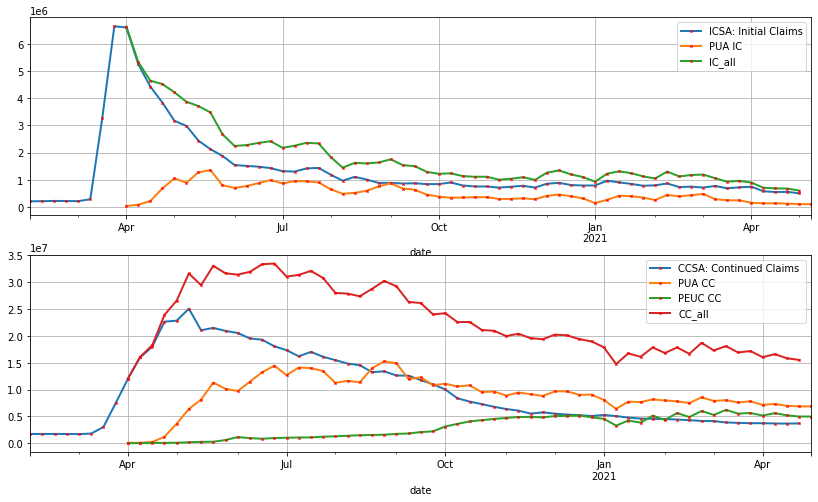

In [6]:
import matplotlib.dates as mdates
figwd = 14
fight= 8
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[figwd, fight], sharex='row')
first_date = '2020-02-01'
temp_ic = ic_df.loc[ic_df["date"] > first_date]
temp_ic.plot(ax=axs[0],  kind='line', linestyle='-', marker='x', lw=2,
                    x='date',
               mec='red', mfc='black', ms=2.2, legend=True, label=None, grid=True)
temp_cc = cc_df.loc[cc_df["date"] > first_date]
temp_cc.plot(ax=axs[1],  kind='line', linestyle='-', marker='x', lw=2,
                    x='date',
               mec='red', mfc='black', ms=2.2, legend=True, label=None, grid=True)
loc = mdates.DayLocator([0,31])
#axs[0].xaxis.set_major_locator(loc)
#axs[0].xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
#axs[1].xaxis.set_major_locator(loc)
#axs[1].xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
plt.show()